In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import pandas as pd
from StringIO import StringIO
import json
import numpy as np
import statsmodels.formula.api as sm

In [50]:
cities = """Atlanta,GA,33.762909,-84.422675
Austin,TX,30.303936,-97.754355
Boston,MA,42.331960,-71.020173
Chicago,IL,41.837551,-87.681844
Cleveland,OH,41.478462,-81.679435
Denver,CO,39.761850,-104.881105
Las Vegas,NV,36.229214,-115.26008
Los Angeles,CA,34.019394,-118.410825
Miami,FL,25.775163,-80.208615
Minneapolis,MN,44.963324,-93.268320
Nashville,TN,36.171800,-86.785002
New Orleans,LA,30.053420,-89.934502
New York,NY,40.663619,-73.938589
Philadelphia,PA,40.009376,-75.133346
Phoenix,AZ,33.572154,-112.090132
Salt Lake City,UT,40.778996,-111.932630
San Francisco,CA,37.727239,-123.032229
Seattle,WA,47.620499,-122.350876
Washington,DC,38.904103,-77.017229"""
citiesDf = pd.read_csv(StringIO(cities), sep=',', header=None)
citiesDf.columns = ['city', 'state', 'latitude', 'longitude']

In [51]:
url = 'http://api.openhouseproject.co/api/property/?offset=0&limit=1500&close_to=({},{},{})'

In [52]:
distance = 100
fields = ['price', 'bathrooms', 'bedrooms', 'building_size']

In [57]:
dfMap = {}

In [114]:
for i in range(citiesDf.shape[0]):
    row = citiesDf.iloc[i]
    city = row.city
    print 'City:', city
    if not(dfMap.has_key(city)):
        lat = row.latitude
        lng = row.longitude
        s = url.format(distance, lat, lng)
        r = requests.get(s)
        o = json.loads(r.content)
        results = o['results']
        properties = []
        for result in results:
            data = {}
            for field in fields:
                data[field] = result[field]
            properties.append(data)
        dfMap[city] = properties

City: Atlanta
City: Austin
City: Boston
City: Chicago
City: Cleveland
City: Denver
City: Las Vegas
City: Los Angeles
City: Miami
City: Minneapolis
City: Nashville
City: New Orleans
City: New York
City: Philadelphia
City: Phoenix
City: Salt Lake City
City: San Francisco
City: Seattle
City: Washington


In [125]:
for city in dfMap.keys():
    df = pd.DataFrame(dfMap[city])
    df['intercept'] = 1
    model = sm.ols(formula="price ~ bedrooms + building_size + intercept", data=df).fit()
    print("CITY: " + city)
    print model.summary()
    print "\n\n\n\n"

CITY: Seattle
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     522.5
Date:                Wed, 02 Nov 2016   Prob (F-statistic):          2.28e-172
Time:                        18:06:08   Log-Likelihood:                -19852.
No. Observations:                1482   AIC:                         3.971e+04
Df Residuals:                    1479   BIC:                         3.972e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      4.954e+04   6276.

As you can see above, the fits need more work to remove multi-colinearity and address cases where some coefficients have low confidence.  But for a quick analysis, let's continue.

In [116]:
params = []
for city in dfMap.keys():
    df = pd.DataFrame(dfMap[city])
    df['intercept'] = 1
    model = sm.ols(formula="price ~ bedrooms + building_size + intercept", data=df).fit()
    d = dict(model.params)
    d['rsquared'] = model.rsquared
    d['city'] = city
    params.append(d)

In [117]:
res = pd.DataFrame(params)
res.sort('building_size', inplace=True)
res.index = np.arange(res.shape[0])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


[]

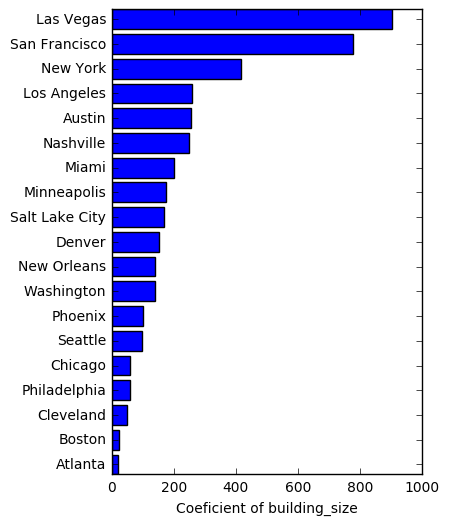

In [124]:
plt.figure(figsize=(4,6))
plt.barh(res.index, res['building_size'])
plt.yticks(res.index + 0.4, res['city'])
plt.xlabel('Coeficient of building_size')
plt.plot()